# Proyecto integrador: Segmentación de clientes según su transaccionalidad
## Integrantes:
 - Karen Lizeth Velasquez Moná
 - Ana María Uran González
 - Daniel Román Ramírez
 - Daniel Enrique Pinto Restrepo
 - Carlos Alberto Cerro Espinal

## Detección y Remoción de Outliers

Cómo parte del proceso del proyecto integrador y de los aprendizajes de las diferentes materias, es necesario detectar outliers en nuestros datos. Con respecto al uso de tarjetas de crédito y del modelo RFM, las variables que se usan son: la edad, total de transacciones y monto total de transacciones. A continuación se describe detalladamente el proceso en el que se incurre.

#### Primero cargamos las librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
#Debemos establecer nuestro directorio de trabajo
os.chdir('C:/Users/K555LB/Documents/Maestría en ciencia de los datos y análitica/Semestre 1/Proyecto Integrador')

#### Luego cargamos nuestra base de datos

In [3]:
bd = pd.read_csv('dataset_banco.csv')

### Detección de Outliers

In [4]:
#Primero generamos la base con las variables a marca
bd_outliers = bd.loc[:,('Monto_transado', 'Total_trx','Edad')]

In [5]:
#Cargamos la librería StandardScaler para estandarizar los datos
from sklearn.preprocessing import StandardScaler
#Con la librería estandarizamos la base de datos de outliers
bd_outliers = StandardScaler().fit_transform(bd_outliers)

In [6]:
#Luego calculamos la matriz de varianzas y covarianzas para utilizarla en la distancia de mahalanobis
cov_matrix = np.cov(bd_outliers, rowvar = False)

In [7]:
#Creo un vector de medias, es con el que voy a detectar mis outliers.
media = bd_outliers.mean(axis = 0)

In [8]:
#Importo de scipy la liberia distancias, es donde obtengo el cálculo de la distancia de mahalanobis
from scipy.spatial import distance

In [9]:
#Creo una columna adicional de ceros en la base de datos de outliers
bd_outliers2 = np.column_stack((bd_outliers, np.zeros(4999)))
#Para cada una de las observaciones mido su distancia a la media que calculamos anteriormente
for i in range(0,np.size(bd_outliers, axis = 0)):
    bd_outliers2[i,3] = distance.mahalanobis(bd_outliers[i,:], media, np.linalg.inv(cov_matrix))

Hasta el momento tenemos las ditancia de cada observación a la media, el siguiente paso es establecer un punto de corte el cual nos indicará si una observación es outlier o no. En nuestro caso, tomamos el 10% de las distancias más alejadas de la media.

In [10]:
#Establecemos una variable cut, que es el punto de corte
cut = np.percentile(bd_outliers2[:,3],90)
#Generamos una variable que me diga 1 si la distancia es mayor a ese punto de corte y 0 si esta por debajo
bd_outliers2 = np.column_stack((bd_outliers2,bd_outliers2[:,3]>cut))

### Graficando mis Outliers

Para gráficar los outliers, vamos a utilizar componentes principales con el objetivo de reducir dimensionalidad y poder gráficar más fácilmente los datos.

In [11]:
"""
Cargamos la libería linalg de numpy para obtener los valores y los vectores propios
de la matriz de covarianzas que habíamos calculado anteriormente
"""
from numpy import linalg as LA
values, vectors = LA.eig(cov_matrix)

In [12]:
print('Estos son mis valores propios')
print(values)
print('                              ')
print('Estos son mis valores propios')
print(vectors)
print('Cómo podemos observar, los útlimos dos son los de más variabilidad')

Estos son mis valores propios
[0.97126887 1.02759717 1.0017342 ]
                              
Estos son mis valores propios
[[ 0.67773899 -0.69408324 -0.24273094]
 [-0.69408403 -0.71285635  0.10041503]
 [ 0.24272868 -0.10042049  0.96488264]]
Cómo podemos observar, los útlimos dos son los de más variabilidad


In [13]:
"""
Luego de calcular nuestros vectores y valores propios, el paso a seguir
es calcular los componentes principales de la siguiente forma
"""
comp1 = np.matmul(bd_outliers,vectors[:,2])
comp2 = np.matmul(bd_outliers,vectors[:,1])

In [14]:
"""
Finalmente creamos un vector indicador para que en el gráfico pueda reflejar los outliers
"""
Indicador = bd_outliers2[:,4]
Indicador = Indicador.astype(bool)

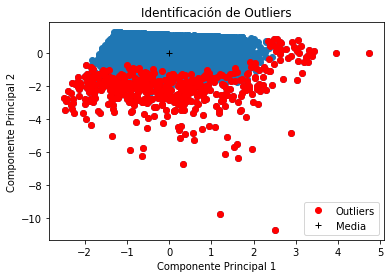

In [19]:
"""
Gráficamos los outliers
"""
plt.plot(comp1, comp2,'o')
plt.plot(comp1[Indicador,], comp2[Indicador,],'ro',label = 'Outliers')
plt.plot(np.matmul(media,vectors[:,2]),np.matmul(media,vectors[:,1]),'k+', label = 'Media')
plt.title('Identificación de Outliers')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(loc='lower right')

## Guardando los cambios

Para finalizar, adjuntamos las dos variables creadas (Distancia, Indicador) a la base anterior y luego filtramos las observaciones que no son outliers

In [20]:
bd['Outliers'] = bd_outliers2[:,4] #Añadimos la variable indicador
bd['Mahal Distance'] = bd_outliers2[:,3] #Añadimos la variable distancia
bd_limpia = bd[bd.Outliers == 0] #Filtramos los datos